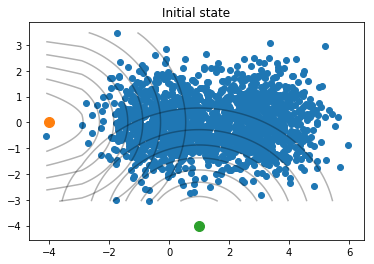

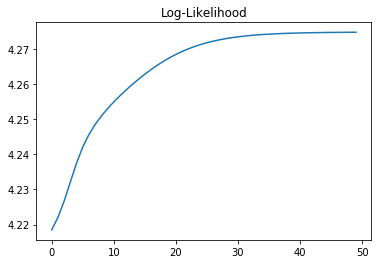

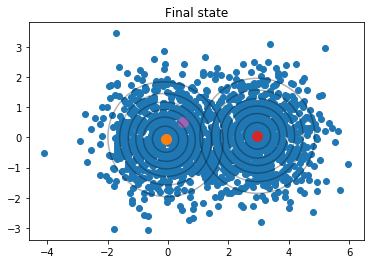

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

filePath1 = "dataset/dataset1.txt"
#filePath2 = "dataset/dataset2.txt"
X = np.loadtxt(filePath1, delimiter=" ",usecols=range(2))

'''for a in open(filePath2):
    lead_space=len(a) - len(a.lstrip())
    X = np.loadtxt(filePath2, delimiter=" ",usecols=range(2))
'''

class GMM:
    def __init__(self,X,number_of_sources,iterations):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        #self.XY = None
        
    
    """Define a function which runs for iterations, iterations"""
    def run(self):
        self.reg_cov = 1e-6*np.identity(len(self.X[0]))
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
        
        # Random initialization of mean vectors and covariance matrices
        self.mu = np.random.randint(min(self.X[:,0]),max(self.X[:,0]),size=(self.number_of_sources,len(self.X[0]))) # This is a nxm matrix since we assume n sources (n Gaussians) where each has m dimensions
        self.mu.shape
        self.cov = np.zeros((self.number_of_sources,len(X[0]),len(X[0]))) # We need a nxmxm covariance matrix for each source since we have m features --> We create symmetric covariance matrices with ones on the digonal
        self.mu.shape
        # Mean and covariance initialized from k-Means Clustering to be included here
        #self.mu=[np.array([ 3.02693997  0.04039995],[-0.12112793 -0.0472586 ])]
        #self.cov=[np.array([[0.78454199, 0.01197598],[0.01197598, 0.95989469]]), np.array([[ 0.81922146, -0.00963075],[-0.00963075,  0.96540313]]), 0]
        #self covariance is always 1
        for dim in range(len(self.cov)):
            np.fill_diagonal(self.cov[dim],5)
        self.pi = np.ones(self.number_of_sources)/self.number_of_sources # Are "Fractions"
        log_likelihoods = [] # For log likehoods per iteration and plot them in the end to check convergence
            
        #Plot the initial randomized state  
        fig = plt.figure()
        ax0 = fig.add_subplot(111)
        ax0.scatter(self.X[:,0],self.X[:,1])
        ax0.set_title('Initial state')
        for m,c in zip(self.mu,self.cov):
            c += self.reg_cov
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax0.scatter(m[0],m[1],s=100)
        
        for i in range(self.iterations):               
            """E Step"""
            r_ic = np.zeros((len(self.X),len(self.cov)))
            for m,co,p,r in zip(self.mu,self.cov,self.pi,range(len(r_ic[0]))):
                co+=self.reg_cov
                mn = multivariate_normal(mean=m,cov=co)
                r_ic[:,r] = p*mn.pdf(self.X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.cov+self.reg_cov)],axis=0)
            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []
            for c in range(len(r_ic[0])):
                m_c = np.sum(r_ic[:,c],axis=0)
                mu_c = (1/m_c)*np.sum(self.X*r_ic[:,c].reshape(len(self.X),1),axis=0)
                self.mu.append(mu_c)
                # Calculate the covariance matrix per source based on the new mean
                self.cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(self.X),1)*(self.X-mu_c)).T,(self.X-mu_c)))+self.reg_cov)
                # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
                self.pi.append(m_c/np.sum(r_ic)) # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know 
                                                # that the columns of each row of r_ic adds up to 1. Since we add up all elements, we sum up all
                                                # columns per row which gives 1 and then all rows which gives then the number of instances (rows) 
                                                # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
                                                # The elements in pi_new must add up to 1
            
            
            """Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))
        fig2 = plt.figure()
        ax1 = fig2.add_subplot(111) 
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(0,self.iterations,1),log_likelihoods)
        plt.show()
    
    """Predict the membership of an unseen, new datapoint"""
    def predict(self,X):
        fig3 = plt.figure()
        ax2 = fig3.add_subplot(111)
        ax2.scatter(self.X[:,0],self.X[:,1])
        for m,c in zip(self.mu,self.cov):
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax2.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax2.scatter(m[0],m[1],s=100)
            ax2.set_title('Final state')
            for x in X:
                ax2.scatter(x[0],x[1],s=100)
        plt.show()
        return #prediction
         
    
    
GMM = GMM(X,2,50)
#GMM = GMM(X,3,50)
GMM.run()
GMM.predict([[0.5,0.5]])